# Graphs & Diagnostics

This notebook creates the diagnostic plots used by the frontend `Graphs` page. It looks for the advertising CSV (several fallbacks) and produces:

1. Correlation heatmap between TV/Radio/Newspaper and Sales
2. Side-by-side Actual vs Predicted for Linear Regression and Random Forest
3. Residuals histogram
4. Feature importances from the Random Forest

All PNGs are saved to `campaign-sales-bot/public/plots/` so the frontend can load them directly.

In [1]:
# Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

sns.set(style='darkgrid')

In [2]:
# Find the CSV using a few sensible fallbacks
candidates = [
    Path('campaign-sales-bot') / 'public' / 'advertising.csv',
    Path('campaign-sales-bot') / 'public' / 'Advertising And Sales.csv',
    Path('advertising.csv'),
    Path('Advertising And Sales.csv'),
]
csv_path = None
for p in candidates:
    if p.exists():
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError(f'Could not find advertising CSV in any of: {candidates}')

print('Using CSV:', csv_path)
df = pd.read_csv(csv_path)
df.head()

FileNotFoundError: Could not find advertising CSV in any of: [WindowsPath('campaign-sales-bot/public/advertising.csv'), WindowsPath('campaign-sales-bot/public/Advertising And Sales.csv'), WindowsPath('advertising.csv'), WindowsPath('Advertising And Sales.csv')]

In [3]:
# Ensure output directory exists (public/plots)
out_plots = Path('campaign-sales-bot') / 'public' / 'plots'
out_models = Path('campaign-sales-bot') / 'public' / 'models'
out_plots.mkdir(parents=True, exist_ok=True)
out_models.mkdir(parents=True, exist_ok=True)

# Correlation heatmap
plt.figure(figsize=(6,5))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Between Spending and Sales')
heatmap_fp = out_plots / 'heatmap.png'
plt.tight_layout()
plt.savefig(heatmap_fp, dpi=150)
plt.close()
print('Saved heatmap to', heatmap_fp)

NameError: name 'df' is not defined

<Figure size 600x500 with 0 Axes>

In [4]:
# Prepare features and target and split
X = df[['TV','Radio','Newspaper']].astype(float)
y = df['Sales'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train/test sizes:', X_train.shape, X_test.shape)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_r2 = r2_score(y_test, lr_preds)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
lr_mae = mean_absolute_error(y_test, lr_preds)
print('Linear R2', lr_r2, 'RMSE', lr_rmse, 'MAE', lr_mae)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Fit RF (may take a moment on large datasets)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_mae = mean_absolute_error(y_test, rf_preds)
print('RF R2', rf_r2, 'RMSE', rf_rmse, 'MAE', rf_mae)

# Save models for server/frontend if desired
joblib.dump(lr, out_models / 'linear.joblib')
joblib.dump(rf, out_models / 'random_forest.joblib')
print('Saved models to', out_models)

NameError: name 'df' is not defined

NameError: name 'y_test' is not defined

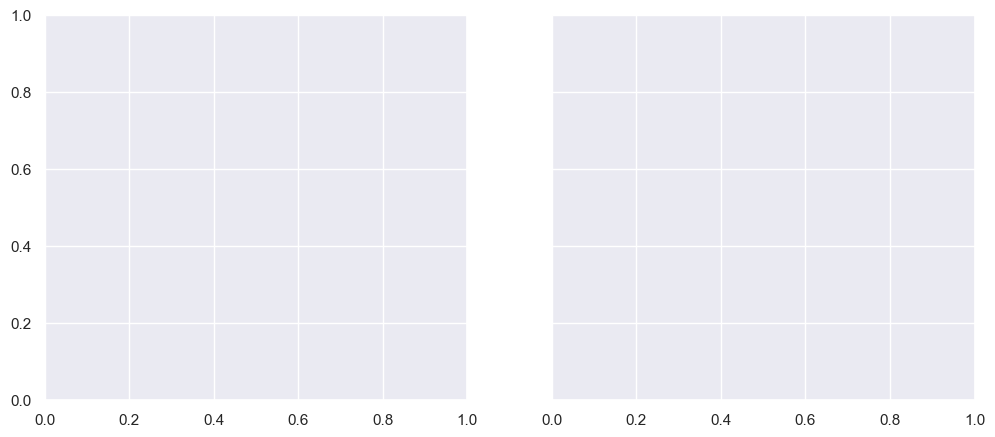

In [5]:
# Side-by-side Actual vs Predicted (Linear vs RandomForest)
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True)
# Diagonal line helper
mn = min(y_test.min(), lr_preds.min(), rf_preds.min())
mx = max(y_test.max(), lr_preds.max(), rf_preds.max())
axes[0].scatter(y_test, lr_preds, color='tab:blue', alpha=0.8)
axes[0].plot([mn,mx],[mn,mx], 'r--')
axes[0].set_title('Linear Regression: Actual vs Predicted')
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales (Linear)')

axes[1].scatter(y_test, rf_preds, color='tab:green', alpha=0.8)
axes[1].plot([mn,mx],[mn,mx], 'r--')
axes[1].set_title('Random Forest: Actual vs Predicted')
axes[1].set_xlabel('Actual Sales')
axes[1].set_ylabel('Predicted Sales (Random Forest)')

plt.tight_layout()
avp_fp = out_plots / 'actual_vs_predicted.png'
plt.savefig(avp_fp, dpi=150)
plt.close()
print('Saved Actual vs Predicted to', avp_fp)

In [6]:
# Residuals histogram (Random Forest residuals as example)
residuals = y_test - rf_preds
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='tab:green')
plt.title('Residuals (Actual - Predicted) -- Random Forest')
plt.xlabel('Residual')
plt.ylabel('Count')
res_fp = out_plots / 'residuals_hist.png'
plt.tight_layout()
plt.savefig(res_fp, dpi=150)
plt.close()
print('Saved residuals histogram to', res_fp)

NameError: name 'y_test' is not defined

In [7]:
# Feature importances from the Random Forest
importances = rf.feature_importances_
feat_names = X.columns.tolist()
fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(data=fi_df, x='importance', y='feature', palette='viridis')
plt.title('Feature Importances (Random Forest)')
fi_fp = out_plots / 'feature_importances.png'
plt.tight_layout()
plt.savefig(fi_fp, dpi=150)
plt.close()
print('Saved feature importances to', fi_fp)

NameError: name 'rf' is not defined

In [8]:
# Report what we saved
for p in sorted(out_plots.iterdir()):
    if p.is_file():
        print(p.name, '-', p.stat().st_size, 'bytes')